In this notebook we apply some of the methods and code of shape_measurement.ipynb to investigate the effect of pixelization and undersampling on metacalibration.
Important papers:

Huff & Mandelbaum https://arxiv.org/pdf/1702.02600.pdf

Sheldon & Huff    https://arxiv.org/pdf/1702.02601.pdf

In [2]:
#Import libraries
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import galsim
from scipy.optimize import curve_fit
import time
from galsim.gsparams import GSParams
from galsim.hsm import HSMParams
from scipy import fftpack
import shape_measurement as sm

ModuleNotFoundError: No module named 'galsim'

In [82]:
#Simulation options
matchRotNans = True #All rotated images of a galaxy are nan if one of them is nan, if True
nrot = 3 #Number of images per galaxy ie 1 is no rotations, 2 is a 0 and 90 degree rot, etc
ngal = 7 #Number of galaxies to simulate
shearList = [(0,0),(0.04,0),(-0.04,0),(0,0.04),(0,-0.04)] #list of shears to apply
g1shear = [shear[0] for shear in shearList]
g2shear = [shear[1] for shear in shearList]

gsparams = galsim.GSParams(maximum_fft_size=12288)

#Parameters of the galaxy flux distribution
m_min, m_max = 19, 25 #min, max magnitudes
m0 = 25

#Parameters of the galaxy ellipticity function
epsilon0 = 0.35
distortion_cutoff = 0.95
shape_parameter_type = 'distortion'

#Other parameters of the galaxy population
disk_n = 0.5  #n for Sersic profile; 1/2 for Gaussian
disk_re = 0.8 #half-light radius, as

#Parameters of the PSF
psf_sigma = 0.5 #as
pixel_scale = 0.1 #as/px

#Parameters of the noise
noise_on = False
noise_sigma = 0.01 #Gives SNR ~300 for m = 20, m0=25

#Airy PSF
lamda = 750 #nm
diameter = 1.2 #m
airy = galsim.Airy(lam=lamda, diam=diameter, scale_unit=galsim.arcsec, obscuration=0.3)
pixel = galsim.Pixel(pixel_scale)
psf = galsim.Convolve(airy, pixel)
image_psf=psf.drawImage(scale=pixel_scale/10.,method='no_pixel')


In [3]:
magArr = np.linspace(m_min,m_max,10000)
mags = sm.draw_samples_specified_distribution(ngal, sm.mag_hist_power_law, magArr, 1)
fluxes = sm.flux(mags, m0)
#Plot histogram
#a=plt.hist(mags, 30, color="k", histtype="step")

In [4]:
distortion = np.random.rayleigh(epsilon0, size=ngal)
#Place cut on distortion as they do in Hoekstra et al 2015
while np.any(distortion>distortion_cutoff):
    high_dist = np.where(distortion>distortion_cutoff)  
    distortion[high_dist] = np.random.rayleigh(epsilon0, size=len(high_dist))
shape_magnitude = distortion

#Generate random numbers for intrinsic galaxy shapes
#shape_params = np.random.random((ngal,2))
phase = np.random.random(ngal)
shape_params = np.stack((shape_magnitude, phase)).transpose()

#Make catalog
#Galaxy ID, Flux/magnitude, size, sersic n, intrinsic ellipticity
galId = range(ngal)
flux = fluxes
size = [disk_re]*ngal
sersic = [disk_n]*ngal
shape1 = list(shape_params[:,0])
shape2 = list(shape_params[:,1] * np.pi)

input_cat = np.stack((galId,flux,size,sersic,shape1,shape2)).transpose()
header = 'galId flux size sersic shape1 shape2 nrot'
np.savetxt('../shear_bias_outputs/input_cat.txt',input_cat,delimiter=' ',header=header)

In [5]:
#load catalog
cat = np.loadtxt('../shear_bias_outputs/input_cat.txt', skiprows=1)
flux = cat[:,1]
disk_reArr, disk_nArr = cat[:,2],cat[:,3]
magArr,phArr = cat[:,4],cat[:,5]

#Generate galaxies
galaxies = [galsim.Sersic(disk_n,half_light_radius=disk_re,gsparams=gsparams) for (disk_re,disk_n) in zip(disk_reArr,disk_nArr)]
galaxies = [gal.withFlux(gal_flux) for gal,gal_flux in zip(galaxies,flux)]
galaxies = [sm.intrinsic_shear(galaxy,shape_parameter_type,mag,ph) for galaxy,mag,ph in zip(galaxies,magArr,phArr)]

#Generate rotated galaxies, add to galaxy list
rotation_angle = [180./(nrot)*i for i in range(1,nrot)]
rot_gals = [gal.rotate(angle*galsim.degrees) for angle in rotation_angle for gal in galaxies]
galaxies += rot_gals

#Shear Galaxies
shearedGals = np.array([[gal.shear(g1=shear[0],g2=shear[1]) for gal in galaxies] for shear in shearList])


In [6]:
startC,startT = time.clock(), time.time()
sim_params = [psf, image_psf, psf_sigma, pixel_scale, disk_reArr, nrot, ngal]
obs, shape_err, error_message = sm.drawGalaxies(shearedGals, -1, True, sim_params)
print 'clock time: %10.1f \n cpu time: %10.1f' % (time.clock()-startC,time.time()-startT)
print 'len(shearedGals) = ', shearedGals.size
print 'Number of errors: ', np.sum(error_message != 0)


clock time:        1.1 
 cpu time:        1.1
len(shearedGals) =  105
Number of errors:  0


In [7]:
weights = np.ones_like(obs)
startC,startT = time.clock(), time.time()
#Find weighted g1 and g2 from e1, e2
meanShear= sm.findMeanShear(obs,weights)
#Use bootstrap method to resample and derive an error on the shear values
size = obs.shape[0]
nBootstrap = int(size*np.log(size)**2)
shearSamples = sm.bootstrapShear(obs,weights,nBootstrap)
errShear = np.std(shearSamples,axis=0) / np.sqrt(nBootstrap)
meanShearBootstrap = np.mean(shearSamples,axis=0)
print 'clock time: %10.1f \n cpu time: %10.1f' % (time.clock()-startC,time.time()-startT)

#Combine mean and err into a single array
res = np.stack((meanShear,errShear)).transpose(2,1,0)
#res Shape: (measurements, shears, (mean, err))

clock time:        0.0 
 cpu time:        0.0


In [8]:
mSamples = sm.bootstrapM(shearSamples,shearList) #shape: numSamples, 2 (g1,g2), SNRs
mStd = np.std(mSamples,axis=0) / np.sqrt(nBootstrap)
mMeanBootstrap = np.mean(mSamples,axis=0)
#mStd shape: ((g1,g2), SNRs)

mMean = sm.getFitParameters(shearList,res)[:,0]

(Large galaxies)
clean up code
(plot vertical line at zero in histogram)
histogram difference in distortions, both components
repeat for half pixel scale and double postage stamp size (independently)
keep track of failed ones in histogram if it fails in one and not the other
upload plot to slides:
Histograms
Some good and some bad images


In [2]:
cc = galsim.COSMOSCatalog(dir='/disks/shear15/KiDS/ImSim/pipeline/data/COSMOS_25.2_training_sample/',use_real=False)


In [5]:
shearList = [(0,0)]
hlr, sn, q = [np.array([pc[4][i] for pc in cc.param_cat]) for i in range(1,4)]

small100I = np.where(hlr*np.sqrt(q)>2.5)[0][100:200]
galaxies = cc.makeGalaxy(small100I, chromatic=False, gsparams=gsparams)

In [6]:
galIms=[]
for gal in galaxies:
    psfgal = galsim.Convolution([gal, psf])
    galIm = psfgal.drawImage(scale=pixel_scale, method='no_pixel')
    galIms.append(galIm)

In [8]:
base_images=[galsim.ImageF(gal.array.shape[0],gal.array.shape[1],scale=pixel_scale) for gal in galIms]

In [9]:
galii = [galsim.InterpolatedImage(gal) for gal in galIms]
psfii = galsim.InterpolatedImage(image_psf)
sheared = [sm.cfGal(gali, psfii, shearList) for gali in galii]
shearedIm = [[sh.drawImage(image=base_images[i],method='no_pixel') for sh in row] for i,row in enumerate(sheared)]
shearedIm = np.array(shearedIm)

# shearedNoE = [cfGalMod(gali,psfii,shearList) for gali in galii]
# shearedImNoE = [[sh.drawImage(scale=pixel_scale, method='no_pixel') for sh in row] for row in shearedNoE]
# shearedImNoE = np.array(shearedImNoE)

In [60]:
print shearedIm.shape

(100, 1)


In [62]:
psf_sigma=1
obsOrig = np.array([sm.measureShape(gal,image_psf, hlr[i]*pixel_scale, psf_sigma, pixel_scale) for i,gal in enumerate(galIms)])
obsConv = np.array([sm.measureShape(gal,image_psf, hlr[i]*pixel_scale, psf_sigma, pixel_scale) for i,gal in enumerate(shearedIm.transpose()[0])])

    #        obsRow = [measureShape(noisyIm, image_psf) for noisyIm in noisyImRow]

In [71]:
e1,e2 = obsOrig.transpose()[0],obsOrig.transpose()[1]
e1c,e2c = obsConv.transpose()[0],obsConv.transpose()[1]


In [73]:
shearedFlat = shearedIm.flatten()
#shearedFlatNoE = shearedImNoE.flatten()
gi=np.array(galIms).reshape(100,1)
gi=np.repeat(gi, 0, axis=1).flatten()

In [150]:
def plotGalSquare(imarr, sz,i=0):
    fig,ax=plt.subplots(sz,sz,figsize=(20,20))
    for i,im in enumerate(imarr[i*sz**2:(i+1)*sz**2]):
        subax=ax[i/sz,i%sz]
        subax.axes.axis('off')
        arr = im.array
        #subax.set_xlim(60,100)
        #subax.set_ylim(60,100)
        subax.imshow(arr,interpolation="none",vmin=0,vmax=0.1*0.001)
    plt.subplots_adjust(hspace=0.1,wspace=0.1)

# plotGalSquare(shearedFlat, 5, 1)
# plotGalSquare(galIms, 5, 1)

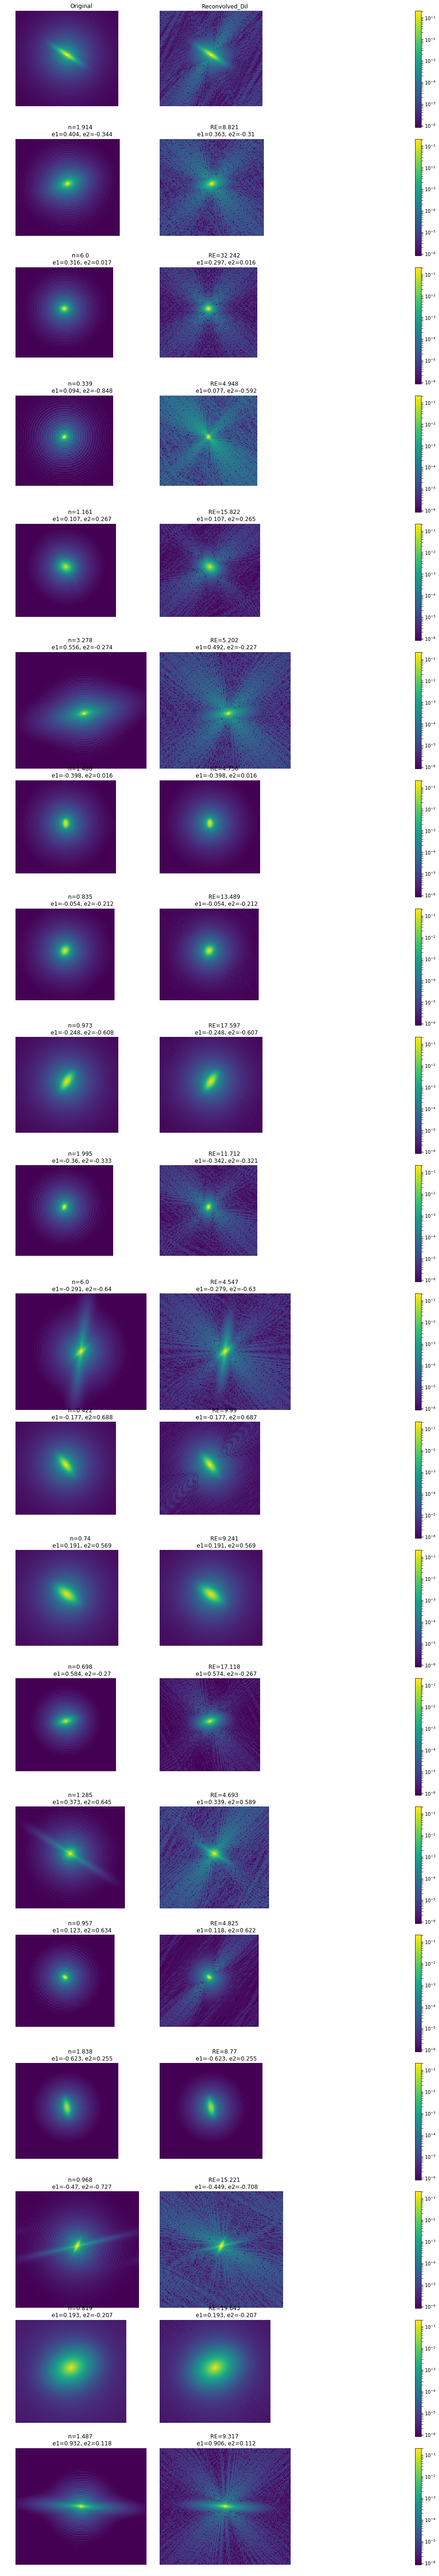

In [81]:
from matplotlib.colors import LogNorm
x=20
zoom = False
vlim = False

if vlim:
    vmax = 0.1
else:
    vmax=None

norm = LogNorm()
fig,ax=plt.subplots(x,3,figsize=(16,100),sharey=True,sharex=True)
for i in range(x):
    subax0,subax1,subax2 = ax[i,0], ax[i,1], ax[i,2]
    subax0.imshow(np.abs(galIms[i].array),interpolation='none',vmax=vmax,norm=norm)
    _im2=subax1.imshow(np.abs(shearedFlat[i].array), interpolation='none', vmax=vmax,norm=norm)
    #_im2 = subax2.imshow(np.abs(shearedFlatNoE[i].array), interpolation='none', vmax=vmax,norm=norm)
    subax0.axes.axis('off');subax1.axes.axis('off');subax2.axes.axis('off')
    title = "RE={0} \n e1={1}, e2={2}".format(np.round(hlr[small100I[i]],3), np.round(e1c[i],3), np.round(e2c[i],3))
    title2 = "n={0} \n e1={1}, e2={2}".format(np.round(sn[small100I][i],3),np.round(e1[i],3), np.round(e2[i],3))    
    subax0.set_title(title2)
    subax1.set_title(title)
    #subax2.set_title(np.round(sn[small100I][i],3))
    if zoom:
        for subax in (subax0,subax1,subax2):
            subax.set_xlim(50,110)
            subax.set_ylim(50,110)
    fig.colorbar(_im2,ax=subax2)
ax[0,0].set_title('Original')
ax[0,1].set_title('Reconvolved_Dil')
#ax[0,2].set_title('Reconvolved_noDil')
plt.subplots_adjust(hspace=0.1,wspace=0.1)
